In [2]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import ast
import re
import nltk
import math

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SESA463805\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SESA463805\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SESA463805\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#issues_df = pd.read_csv('5_25_validation.csv')
issues_df = pd.read_csv('6_21_validation.csv')

FileNotFoundError: [Errno 2] File 6_21_validation.csv does not exist: '6_21_validation.csv'

In [2012]:
issues_df.head()

,Unnamed: 0,Case Number,Date,Severity,Customer Request,triplets
0,0,46181136,2018-02-01,Normal,Name: David Rosell\nPhone: 7862264495\nConcern...,"[('EBX510', 'ISSUE', 'has changed the trip uni..."
1,1,48164862,2018-04-01,Normal,Name: Albert Sarkis\nPhone: (209) 744-1513\nCo...,"[('RJF36160U44A', 'CONTEXT', 'having nuisance ..."
2,2,46224073,2018-02-01,Normal,Please process the attached supplier recovery ...,[]
3,3,46237499,2018-02-01,Normal,A Request for Test Report on InOperative Produ...,"[('LC36400 breaker', 'ISSUE', 'stuck in the cl..."
4,4,45184334,2018-01-01,Normal,2301002465\nLV431629 x 1 Faulty\nFailed when t...,"[('LV431629', 'ISSUE', 'faulty failed when try..."


### Thresholding Impact
- 80% for all relations
    - 31% w no issues detected (776 / 2451)
- 90% for all relations
    - 34% w no issues detected (826 / 2451)

In [2355]:
stop_words = ['a','about','above','after','again','against','ago','ain','all','am','an','and','any','are','aren',"aren't",'as',
              'at','be','because','been','before','being','below','between','both','but','by','can','couldn',"couldn't",'d',
              'did','didn',"didn't",'do','does','doesn',"doesn't",'doing','don',"don't",'double','down','during','each','few','for',
              'from','further','had','hadn',"hadn't",'has','hasn',"hasn't",'have','haven',"haven't",'having','he','her','here',
              'hers','herself','him','himself','his','how','i','if','in','into','is','isn',"isn't",'it',"it's",'its','itself',
              'just','know','know','ll','m','ma','me','mightn',"mightn't",'more','most','mustn',"mustn't",'my','myself','need','needs','needn',"needn't",
              'no','nor','now','o','of','off','on','once','only','or','other','our','ours','ourselves','out','over','own','re','s',
              'same','shan',"shan't",'she',"she's",'should',"should've",'so','some','such','sure','t','than','that',"that'll",'the',
              'their','theirs','them','themselves','then','there','these','they','this','those','through','to','too','under',
              'until','up','ve','very','was','wasn','we','were','weren','what','when','where','which','while','who','whom',
              'why','will','with','won','y','you',"you'd","you'll","you're","you've",'your','yours','yourself','yourselves']

add_stop_words=['schneider','electric','brand','subject','reply','fwd','dear','kindly','kind','fw','re','please','regards',
               'sir','team','hello','hi','hey','guy','guys','pl','pls','would','xls','xlsx','jpeg','png','pdf','jpg'
               'xml','noreply','sent','fyi','pfa','could','also','iso','madam','plz','nature','defect','good','morning','ref','case',
               'defective','product','details','detail','mr']

stop_words_custom = list(set(stop_words + add_stop_words))

In [2070]:
from collections import defaultdict

flatten_list = lambda docs: [x for sublist in docs for x in sublist]

def isolate_issues(triplets):
    response = []
    
    triplets = ast.literal_eval(triplets)
    for trip in triplets:
        if trip[1] == 'ISSUE':
            response.append(trip[2])
    return response


def isolate_context(triplets):
    response = []
    
    triplets = ast.literal_eval(triplets)
    for trip in triplets:
        if trip[1] == 'CONTEXT':
            response.append(trip[2])
    return response


def isolate_issueContext(triplets):
    response = []
    response_dict = defaultdict(list)
    
    triplets = ast.literal_eval(triplets)
    
    # loop through triplets collecting entity, relation, and extraction
    for trip in triplets:
        if trip[1] in ['CONTEXT', 'ISSUE']:
            response.append(trip[:3])
            
    # collapse extractions on entity
    for entity, _, extract in response:
        response_dict[entity].append(extract)
    
    # empty responses and add joined entity collapsed data
    response = []
    for key, val in response_dict.items():
        response.append(': '.join(val))
    return response


def clean_sentence(string, stem=False):
    global stop_words_custom
    string = re.sub('[^A-Za-z0-9]+', ' ', string)
    sent = string.lower()
    words = word_tokenize(sent)
    words= [w for w in words if not w in stop_words_custom]
    words = [i for i in words if len(i) < 15]
    sent = ' '.join(word for word in words)
    return sent


def clean_issues(sentlist):
    resultsentlist = []
    
    for senttoken in sentlist:
        sent = clean_sentence(senttoken)
        if 'email' not in sent:
            resultsentlist.append(sent)
    result = list(set(resultsentlist))
    return result

In [2071]:
issues_df['issues'] = issues_df['triplets'].apply(isolate_issues)
issues_df['issues_cleaned'] = issues_df['issues'].apply(clean_issues)

issues_df['context'] = issues_df['triplets'].apply(isolate_context)

issues_df['text'] = issues_df.apply(lambda x: x['context'] if x['issues'] == [] else x['issues'], axis=1)
issues_df['text_clean'] = issues_df['text'].apply(clean_issues)

issues_df['context_issue'] = issues_df['triplets'].apply(isolate_issueContext)
issues_df['context_issue_cleaned'] = issues_df['context_issue'].apply(clean_issues)

In [2072]:
issues_stacked = issues_df.context_issue_cleaned.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('Issues').dropna()
issues_stacked = issues_df.drop('context_issue_cleaned', axis=1).join(issues_stacked, how='inner').reset_index(drop=True) ## To avoid missing Issues use inner join

In [2073]:
emb_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
#emb_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Some weights of the model checkpoint at /home/ec2-user/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-stsb-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1168]:
issue_embeddings = emb_model.encode(flatten_list(issues_df['context_issue_cleaned'].values), show_progress_bar=True)
#issue_embeddings = emb_model.encode(flatten_list(issues_df['text_clean'].values), show_progress_bar=True)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

### U-MAP/ HDBscan
- be right for what it can, and defer on anything that it couldn’t have sufficient confidence in
- classifies many points/docs as "noise"
- [UMAP documentation link](https://umap-learn.readthedocs.io/en/latest/clustering.html)
- [HDBScan documentation link](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

In [3373]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import hdbscan
import umap


tfidf_vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.0015, ngram_range=(1,2)) #
feature_matrix = tfidf_vectorizer.fit_transform(flatten_list(issues_df['context_issue_cleaned'].values))
print(feature_matrix.shape)

umap_model = umap.UMAP(n_neighbors=30,
                            min_dist=0.0,
                            n_components=10,
                            metric='hellinger')
umap_embeddings = umap_model.fit_transform(feature_matrix)

(2515, 943)


In [3574]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15, 
                          min_samples=1,
                          cluster_selection_method='eom').fit(umap_embeddings)

In [3575]:
docs_df = pd.DataFrame(flatten_list(issues_df['context_issue_cleaned'].values), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [3576]:
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words_custom, min_df=0.001).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(flatten_list(issues_df['context_issue_cleaned'].values)))

In [3577]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,359
1,0,182
19,18,83
58,57,81
62,61,80
60,59,67
27,26,60
16,15,59
10,9,47
42,41,46


In [3578]:
topic_sizes.count()

Topic    67
Size     67
dtype: int64

In [3579]:
from sklearn.metrics.pairwise import cosine_similarity

data = flatten_list(issues_df['context_issue_cleaned'].values)
                    
for i in range(10):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ', '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

print(topic_sizes.count())
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

Topic     58
Doc       58
Doc_ID    58
dtype: int64


,Topic,Size
0,-1,422
1,0,199
18,17,99
51,50,81
54,53,80
24,23,75
52,51,67
15,14,59
9,8,47
38,37,46


In [3580]:
def clean_dups(topic):
    words = word_tokenize(topic)
    if (len(words)==2) &\
       (len(set(words))==1):
        return list(set(words)).pop()
    else:
        return topic


word_count = lambda x: len(word_tokenize(x))
def clear_redundent_unigrams(topics):
    unigrams = [x for x in topics if word_count(x) == 1] 
    bigrams = [x for x in topics if word_count(x) == 2]
    
    bigrams.reverse()
    for bi in bigrams:
        words = word_tokenize(bi)
        if words[1] + ' ' + words[0] in bigrams:
            topics.remove(bi)
            bigrams.remove(bi)
            
    for uni in unigrams:
        uni_rank = topics.index(uni)
        for bi in bigrams:
            bi_rank = topics.index(bi)
            
            if (uni in bi) & (uni in topics):
                topics.remove(uni)
                    
    return topics

In [3581]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=6)

for cluster, topics in top_n_words.items():
    # clear duplicates
    topics = [clean_dups(top) for top, score in topics]
    
    # remove duplicates, list(set) loses ordering
    final_topics = []
    [final_topics.append(x) for x in topics if x not in final_topics]
    
    # clear unigrams that repeat in bigrams
    final_topics = clear_redundent_unigrams(final_topics)
    
    # return top 3 words as string
    topic_dict[cluster] = ', '.join(final_topics[0:3])
    
topics = pd.DataFrame(topic_dict, index=[0]).T.reset_index()
topics.iloc[:20]

,index,0
0,-1,"not, breaker, tripping"
1,0,"tripping randomly, breaker tripping"
2,1,"still warranty, warranty claim"
3,2,"shunt trip, 120v shunt, breaker shunt"
4,3,"keeps tripping, breaker keeps, tripping breaker"
5,4,"failure, damaged, po"
6,5,"ground fault, fault relay, fault protection"
7,6,"not aware, aware issues, specified"
8,7,"bad, correctly, tech support"
9,8,"nuisance tripping, catalog"


In [3449]:
#top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=3)
#
#topic_dict = {}
#for cluster, topics in top_n_words.items():
#    topic_dict[cluster] = ', '.join([x for x,y in topics])
#    
#topics = pd.DataFrame(topic_dict, index=[0]).T.reset_index()
#topics.iloc[:5]

,index,0
0,-1,"not, breaker, tripping"
1,0,"tripping, tripping tripping, randomly"
2,1,"warranty, warranty warranty, still warranty"
3,2,"shunt, shunt trip, trip"
4,3,"keeps, keeps tripping, tripping"


In [3582]:
cluster_df = pd.merge(docs_df, topics, left_on='Topic', right_on='index').drop(['Doc_ID', 'index'], axis=1)
cluster_df.columns = ['Issue', 'Cluster', 'Topic']
print('Total Clusters: ', cluster_df['Topic'].value_counts().count())
cluster_df['Topic'].value_counts().head(40)

Total Clusters:  57


not, breaker, tripping                              422
tripping randomly, breaker tripping                 199
stuck, position, not close                           99
request, tex, order                                  81
display, amp, lighting                               80
trip unit, micrologic trip, function                 75
ifm, modbus, address                                 67
testing, injection, long time                        59
nuisance tripping, catalog                           47
breaker trips, lightning, weekend                    46
inrush, thermal, time                                45
failure, damaged, po                                 43
circuit breaker, downstream, option                  43
not trip, trip breaker, short circuit                42
not reset, stop, reset breaker                       42
power supply, not power, external                    39
mail faulty, fax mail                                39
tripped breaker, not tripped                    

### Merge "Noise" cluster with most similar clusters

In [3559]:
noise_inds = cluster_df[cluster_df['Cluster'] == -1].index

noise = cluster_df.loc[noise_inds].drop(['Cluster', 'Topic'], axis=1)
classified = cluster_df.drop(noise_inds)

In [3560]:
# compute feature matrix for previous "noise"
feature_matrix = tfidf_vectorizer.transform(noise['Issue'].values)

# compute topic feature matrix for previous topics (ignoring "noise" i.e. -1)
topic_matrix = tfidf_vectorizer.transform(docs_per_topic.Doc.values[1:])

similarity = cosine_similarity(feature_matrix, topic_matrix)
top = np.argmax(similarity, axis=1)

# get top cluster and scores for all docs
top_scores = [(x, similarity[i][x]) for i, x in enumerate(top)]

# if tf_idf score over 5% add to new cluster else keep as noise
noise['Cluster'] = [x[0] if x[1] > 0.05 else -1 for x in top_scores]

In [3561]:
noise = pd.merge(noise, topics, left_on='Cluster', right_on='index')
noise = noise.drop('index', axis=1)
noise.columns = ['Issue', 'Cluster', 'Topic']

noise.loc[noise['Cluster'] == -1, 'Topic'] = 'Noise'

In [3562]:
cluster_df = classified.append(noise)

In [3563]:
topic_gen = (i for i in cluster_df['Topic'].unique())

In [3594]:
topic = next(topic_gen)
print(topic)
print('Instances: ', cluster_df[cluster_df['Topic'] == topic]['Topic'].count())

cluster_df[cluster_df['Topic'] == topic]['Issue'].values

settings, micrologic 2e, changes
Instances:  19


array(['demonstration unit get micrologic settings ltu not work micrologic demonstration unit get micrologic settings',
       'get micrologic settings',
       'dryer dryer dryer honeywell panel borehole chiller control panel protection micrologic 2e 160a pressing reset not clear message not possible test units input protection settings',
       'successful test micrologic 2e switchboard',
       'tripping several occasions customer wanted someone help understand settings tripping',
       'settings', 'micrologic 6 0a troubles tripping troubles tripping',
       'dead micrologic',
       'display wont come want set gfi settings already tried press key options',
       'changes dials',
       'micrologic electronic trip l provides type coordination',
       '1600a r frame 0p trip unit spontaneously changes trip settings nuisance tripping micrologic unit',
       'spontaneously changes trip settings nuisance tripping nuisance tripping',
       'spontaneously changes trip settings',
    

In [3595]:
cases_df = pd.merge(issues_stacked[['Case Number', 'Date', 'Severity', 'Customer Request', 'Issues']],
                    cluster_df[['Issue', 'Cluster', 'Topic']], 
                    left_on='Issues',
                    right_on='Issue',
                    how='inner').drop_duplicates().reset_index()

bi_cluster = cases_df.groupby('Case Number')['Cluster'].apply(list)
tfidf_cluster = cases_df.groupby('Case Number')['Topic'].apply(set)
cases_df = pd.merge(issues_df, bi_cluster, on='Case Number', how='left').merge(tfidf_cluster, on='Case Number')

In [3596]:
nlp = spacy.load('spacy_ner_may11/')

In [3615]:
sample = cases_df.sample(1)
spacy.displacy.render(nlp(sample['Customer Request'].values[0]), style='ent')

for trip in ast.literal_eval(sample['triplets'].values[0]):
    print('\n', '-'*100)
    print(f'PRODUCT: {trip[0]}')
    print(f'RELATION: {trip[1]}')
    print(f'TEXT: {trip[2]}')

if sample['Cluster'].values[0] == [-1]:
    print('Cluster Unassigned')
else:
    print('\nUMap Clusters: ', sample['Topic'].values[0])


 ----------------------------------------------------------------------------------------------------
PRODUCT: Main Breaker
RELATION: CONTEXT
TEXT: failure rush on the rma

 ----------------------------------------------------------------------------------------------------
PRODUCT: Main Breaker
RELATION: ISSUE
TEXT: failure

 ----------------------------------------------------------------------------------------------------
PRODUCT: Main Breaker
RELATION: LOCATION
TEXT: rma

 ----------------------------------------------------------------------------------------------------
PRODUCT: Panel
RELATION: CONTEXT
TEXT: fort wayne ad zone cell ad320b05

 ----------------------------------------------------------------------------------------------------
PRODUCT: Panel
RELATION: ISSUE
TEXT: no power from columns to east to west and from tt to gg north to south

 ----------------------------------------------------------------------------------------------------
PRODUCT: bad main breaker
REL

## Clustering

In [957]:
from sklearn.cluster import KMeans

In [958]:
def calculate_wcss(data, rand): 
    wcss = []
    for n in tqdm(range(2, 100)):
        kmeans = KMeans(n_clusters=n, random_state=rand)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    plt.figure()
    sns.lineplot(range(2, 100), wcss)
    plt.title('Within Cluster Sum of Squared Error');
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()
    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]
    distances = []
    
    for i in tqdm(range(len(wcss))):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
        
    return distances.index(max(distances)) + 2

  0%|          | 0/98 [00:00<?, ?it/s]

K value not provided, estimating optimal no of clusters
calculating the within clusters sum-of-squares


100%|██████████| 98/98 [05:13<00:00,  3.20s/it]
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


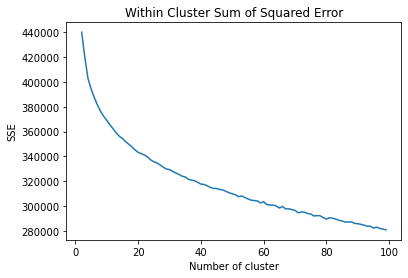

100%|██████████| 98/98 [00:00<00:00, 383792.52it/s]


calculating the optimal number of clusters
Optimal no of clusters :  20


array([16,  6,  5, ..., 18, 13, 10], dtype=int32)

In [959]:
print("K value not provided, estimating optimal no of clusters")
print("calculating the within clusters sum-of-squares")
sum_of_squares = calculate_wcss(issue_embeddings, 43) #, op_dir, filename
print("calculating the optimal number of clusters")
n = optimal_number_of_clusters(sum_of_squares)
print("Optimal no of clusters : ", n)

kmeans = KMeans(n_clusters = n, random_state=43)
y_kmeans = kmeans.fit_predict(issue_embeddings)
y=y_kmeans+1
y

In [977]:
extended_clusters = int(n*1.5)

#clustering_model = KMeans(n_clusters=n, random_state=26)
clustering_model = KMeans(n_clusters=extended_clusters, random_state=0)

clustering_model.fit(issue_embeddings)
cluster_assignment = clustering_model.labels_

## Analyze Clusters

In [978]:
clusterdf = pd.DataFrame()
clusterdf['Issues']=flatten_list(issues_df['context_issue_cleaned'].values)
#clusterdf['Issues']=flatten_list(issues_df['text_clean'].values)

clusterdf['cluster']=cluster_assignment
print(clusterdf.shape)

(2515, 2)


In [979]:
clusterdf.head(10)

,Issues,cluster
0,changed trip unit,14
1,nuisance tripping nuisance tripping,10
2,catalog,22
3,stuck closed position,28
4,faulty failed trying operate,7
5,original po send headley ellis,22
6,tolerances trip 463s,24
7,rotary handles breaking,14
8,fail,28
9,circuit breaker fail,6


In [980]:
clusterdf['cluster'].value_counts()

5     126
3     124
22    121
14    116
24    110
1     109
6     100
0      99
29     96
17     94
16     91
9      91
7      90
28     89
21     89
25     85
18     82
23     81
11     79
13     78
27     75
2      71
20     69
15     66
8      65
19     58
4      54
10     38
12     36
26     33
Name: cluster, dtype: int64

### Cluster Tf-idf matrix

In [1013]:
feature_matrix = tfidf_vectorizer.fit_transform(clusterdf['Issues'].values)

  1%|          | 1/98 [00:00<00:11,  8.37it/s]

K value not provided, estimating optimal no of clusters
calculating the within clusters sum-of-squares


100%|██████████| 98/98 [01:51<00:00,  1.14s/it]
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


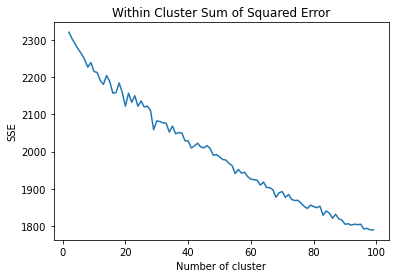

100%|██████████| 98/98 [00:00<00:00, 542271.49it/s]


calculating the optimal number of clusters
Optimal no of clusters :  29


array([ 7, 26, 17, ...,  8,  8, 16], dtype=int32)

In [1046]:
print("K value not provided, estimating optimal no of clusters")
print("calculating the within clusters sum-of-squares")
sum_of_squares = calculate_wcss(feature_matrix, 43) #, op_dir, filename
print("calculating the optimal number of clusters")
n = optimal_number_of_clusters(sum_of_squares)
print("Optimal no of clusters : ", n)

kmeans = KMeans(n_clusters = n, random_state=43)
y_kmeans = kmeans.fit_predict(feature_matrix)
y=y_kmeans+1
y

In [1047]:
clustering_model = KMeans(n_clusters=n, random_state=0)

clustering_model.fit(feature_matrix)
cluster_assignment = clustering_model.labels_

In [1048]:
clusterdf = pd.DataFrame()
clusterdf['Issues']=flatten_list(issues_df['context_issue_cleaned'].values)
#clusterdf['Issues']=flatten_list(issues_df['text_clean'].values)

clusterdf['cluster']=cluster_assignment
print(clusterdf.shape)

(2515, 2)


In [1051]:
terms = tfidf_vectorizer.get_feature_names()
cluster_centers = clustering_model.cluster_centers_

# Display the top_n terms in that cluster
key_terms = []
for i in range(n):
    # Sort the terms and print top_n terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    key_terms.append(sorted_terms[:5])

In [1054]:
cluster_terms = pd.DataFrame([', '.join(words) for words in key_terms], columns=['Top Terms']).reset_index()
tfidf_clusters = pd.merge(clusterdf, cluster_terms, left_on='cluster', right_on='index')
tfidf_clusters.head()

,Issues,cluster,index,Top Terms
0,changed trip unit,21,21,"trip, trip unit, unit, shunt, shunt trip"
1,tolerances trip 463s,21,21,"trip, trip unit, unit, shunt, shunt trip"
2,not trip,21,21,"trip, trip unit, unit, shunt, shunt trip"
3,catalog breaker not trip,21,21,"trip, trip unit, unit, shunt, shunt trip"
4,tripping due shunt trip,21,21,"trip, trip unit, unit, shunt, shunt trip"


In [1055]:
tfidf_clusters['Top Terms'].value_counts()

faulty, load, issue, breakers, main                                       1728
trip, trip unit, unit, shunt, shunt trip                                   147
power, supply, power outage, outage, not power                              74
phase, lost, phase loss, loss, blue                                         62
trips, breaker trips, load trips, trips instantly, load                     58
tripped, breaker tripped, tripped breaker, main, main breaker               54
display, unit, lcd, unit display, display faulty                            48
position, stuck, trip position, tripped position, open                      42
nuisance, nuisance tripping, tripping breaker, trip, tripping nuisance      39
failed, test, panel, report, nsx                                            38
reset, not reset, breaker not, breaker reset, tripped not                   30
voltage, low voltage, low, current, relay                                   27
ground fault, ground, fault, fault protection, fault

In [1068]:
tfidf_clusters[tfidf_clusters['Top Terms'] == 'display, unit, lcd, unit display, display faulty']['Issues'].sample(10).values

array(['needs new trip unit display', 'factory not getting display',
       'display not powered',
       '600a main set 500a not get display come complete settings study',
       'cleared alarm 47 breaker display blank', 'display went',
       'needs new trip unit display faulty display faulty',
       'display lcd micrologic trip unit display',
       'main incoming feed red light display',
       'display trip unit showing dashed lines'], dtype=object)

## Labeling Clusters

#### Bi-gram/Uni-gram

In [981]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

In [982]:
unq_clust = clusterdf["cluster"].unique()

lemmatizer = WordNetLemmatizer()
label_df = pd.DataFrame()

for uc in tqdm(unq_clust):
    try:
        tmp_clust_df = clusterdf.loc[clusterdf['cluster']==uc].copy()
        temp_clust_corpus = list(set(tmp_clust_df['Issues'].dropna().to_list()))
        
        chunks_list =[]
        wc_dict = Counter()
        c_vec = CountVectorizer(ngram_range=(2, 2)) #min_n=1, max_n=2 #ngram_range=(1, 5) , min_df=0.5
        for chunks in temp_clust_corpus:
            words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(chunks)]
            wc_dict.update(word for word in words)
            chunks_list.append(words)
        
        label = wc_dict.most_common(1)[0][0]
        
        bigrams = c_vec.fit_transform(temp_clust_corpus)
        vocab = c_vec.vocabulary_
        count_values = bigrams.toarray().sum(axis=0)
        bigram_count = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
        
        bigram_label = bigram_count[0][1]
        
        flag_var = 2 if label in bigram_label.split(" ") else 1 ## or (bigram_label.find(label)>=0)
        #& label != 'not'
        
        lb_df = pd.DataFrame({'Cluster2': bigram_label, 'Cluster1': label, 'Cluster_Flag': flag_var, 'cluster' : uc}, index=[0]) #, 'Cluster1_root': root
        label_df = label_df.append(lb_df, ignore_index = True)
    except:
        pass

100%|██████████| 30/30 [00:01<00:00, 15.13it/s]


In [983]:
label_df.loc[label_df['Cluster_Flag']==1, 'Cluster'] = label_df['Cluster1']
label_df.loc[label_df['Cluster_Flag']==2, 'Cluster'] = label_df['Cluster2']
label_df

,Cluster2,Cluster1,Cluster_Flag,cluster,Cluster
0,trip unit,trip,2,14,trip unit
1,nuisance tripping,trip,1,10,trip
2,purchase order,warranty,1,22,warranty
3,not working,not,2,28,not working
4,not working,not,2,7,not working
5,alarm phase,phase,2,24,alarm phase
6,circuit breaker,breaker,2,6,circuit breaker
7,not working,not,2,18,not working
8,blue phase,low,1,23,low
9,not closing,not,2,8,not closing


In [984]:
labeled_clusters = pd.merge(clusterdf, label_df, on='cluster')

In [985]:
labeled_clusters['Cluster'].value_counts()

not working         261
trip                259
trip unit           201
not                 171
main breaker        126
breaker             124
warranty            121
alarm phase         110
breaker tripping    109
circuit breaker     100
power                99
test                 94
breaker not          91
breaker tripped      91
low                  81
communication        79
ground fault         71
light                69
high                 66
not closing          65
faulty goods         58
need                 36
still close          33
Name: Cluster, dtype: int64

#### TF-IDF

In [986]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.001, ngram_range=(1,2))
#tfidf_vectorizer.fit(clusterdf['Issues'].values)
tfidf_vectorizer.fit(issues_df['Customer Request'].values)


unq_clust = clusterdf["cluster"].unique()
# unq_clust = [0,1,2,62,226,46,613,687]
unq_clusterdf = pd.DataFrame()

for uc in tqdm(unq_clust):
    tmp_clust_df = clusterdf.loc[clusterdf['cluster']==uc].copy()
    #NEW
    chunks = [word_tokenize(x) for x in list(set(tmp_clust_df['Issues'].dropna().to_list()))]
    chunk_corpus = ([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in flatten_list(chunks)])
    
    tmp_df = pd.DataFrame({"cluster": uc, 'text': [', '.join(chunk_corpus)]})
    unq_clusterdf = unq_clusterdf.append(tmp_df, ignore_index = True) 

tfidf_matrix = tfidf_vectorizer.transform(unq_clusterdf.text.dropna())
print(tfidf_matrix.shape)

100%|██████████| 30/30 [00:01<00:00, 16.56it/s]

(30, 26490)


In [987]:
tfidf_matrix_lst = list(tfidf_matrix)
# print(tfidf_matrix_lst[0].toarray())

tfidf_terms = tfidf_vectorizer.get_feature_names()
term_lst = []
score_lst = []

for e in tfidf_matrix_lst:
    top_n_term_indx = np.argsort(e.toarray())[0][::-1][:4]
    term_lst.append(list(map(tfidf_terms.__getitem__, top_n_term_indx)))
    score_lst.append(list(map(e.toarray()[0].__getitem__, top_n_term_indx)))

unq_clust = pd.DataFrame(unq_clust)
unq_clust['Cluster_tfidf'] = term_lst
unq_clust['Score_tfidf'] = score_lst

labeled_clusters = pd.merge(labeled_clusters, unq_clust, left_on='cluster', right_on=0)
labeled_clusters['Cluster_tfidf'] = list(labeled_clusters['Cluster_tfidf'].apply(lambda x: ', '.join(x)))

In [988]:
labeled_clusters['Cluster_tfidf'].value_counts()

position, main breaker, breaker trip, tripped          126
breaker trip, phase, circuit, circuit breaker          124
warranty, purchase, capture, original purchase         121
feed, keep, lug, turn                                  116
phase, item, alarm, q2c                                110
breaker trip, trip breaker, breaker breaker, turn      109
fail, lose, close, disconnect                          100
generator, voltage, transfer, feed                      99
fail, close, not reset, reset                           96
reset, micrologic, correctly, mccb                      94
breaker not, reset, close, unable                       91
tripped, breaker tripped, breaker trip, outage          91
not work, faulty, work, fail                            90
not power, not light, display, not work                 89
tex, tex request, fault, delivery                       89
injection, feed, main trip, meter                       85
faulty, bad, fault not, properly                        

In [996]:
labeled_clusters[labeled_clusters['Cluster_tfidf'] == 'light, display, ap, red light']['Issues'].values

array(['picture settings breaker', 'lights lit', 'know indicators lit',
       'almost caught fire', 'alarm', 'get display light',
       'supplying rooftop lightings load',
       'theatrical lighting something leaking', 'photos',
       'nema 3r enclosure ambient sometimes hot',
       'main incoming feed red light display', 'buzzing burning',
       'video faq wire uvr', 'err display',
       'nuisance tripping ap light coming nuisance tripping',
       'display lcd', 'display lcd micrologic trip unit display',
       'lightning', 'display', 'rca', 'indicator lights power power',
       'settings', 'assistance uv trip', 'erms flashing display',
       'smoking', 'line panel installed outdoors',
       'primary njection test getting unexpected request warning light',
       'j frames j frames flashing', 'lcd screens appear',
       'display flashes un able change settings',
       'second light left warning', 'indicator light', 'video', 'uvr',
       'ad320 pdp panel', 'lighting', 'g

In [972]:
cases_df = pd.merge(issues_stacked[['Case Number', 'Date', 'Severity', 'Customer Request', 'Issues']],
                    labeled_clusters[['Issues', 'cluster', 'Cluster', 'Cluster_tfidf']], 
                    on='Issues', 
                    how='inner').drop_duplicates().reset_index()

bi_cluster = cases_df.groupby('Case Number')['Cluster'].apply(list)
tfidf_cluster = cases_df.groupby('Case Number')['Cluster_tfidf'].apply(set)
cases_df = pd.merge(issues_df, bi_cluster, on='Case Number', how='left').merge(tfidf_cluster, on='Case Number')

In [973]:
cases_df.sample(10)

,Unnamed: 0,Case Number,Date,Severity,Customer Request,triplets,issues,context,text,text_clean,context_issue,context_issue_cleaned,Cluster,Cluster_tfidf
40,67,48113328,2018-04-01,Normal,FAULTY DISPLAY - SE Technician is on site to t...,"[('breaker', 'CONTEXT', 'faulty display - se t...",[],[faulty display - se technician is on site to ...,[faulty display - se technician is on site to ...,[faulty display se technician site test commis...,[faulty display - se technician is on site to ...,[faulty display se technician site test commis...,[faulty],"{faulty, fault, error, delivery}"
813,1277,63062809,2019-09-01,Normal,RMA: SO#740260635 QTY 3 AL250JD for DLR account,"[('AL250JD', 'CONTEXT', 'dlr account', 0.95508...",[],"[dlr account, qty 3 al250jd for dlr account]","[dlr account, qty 3 al250jd for dlr account]","[qty 3 al250jd dlr account, dlr account]","[dlr account, qty 3 al250jd for dlr account]","[qty 3 al250jd dlr account, dlr account]","[phase, phase]","{phase, year, amp, alarm}"
410,641,53191051,2018-10-01,Normal,TEX Requests - TRANE WARRANTY PROGRAM CASE - B...,"[('Breakers', 'CONTEXT', 'warranty program cas...",[],[warranty program case],[warranty program case],[warranty program],[warranty program case],[warranty program],[warranty],"{warranty, capture, purchase, phase}"
278,445,52516023,2018-10-01,Normal,SEE ATTACHED EMAIL:-\nFrom: Stephen Spiers [ma...,"[('MCCB . .', 'ISSUE', 'still inside the warr...","[still inside the warranty period, the mccb ha...","[original purchase order, our original purchas...","[still inside the warranty period, the mccb ha...","[failed, still inside warranty period, mccb fa...","[still inside the warranty period, original pu...","[failed, lv430630 160a 3p mccb, still inside w...","[not working, phase, test, faulty, phase]","{fail, bad, faulty, not work, reset, correctly..."
1185,1866,57326501,2019-03-01,Normal,Hi Team \n \n Can you please create the unde...,"[('Trip Unit', 'ISSUE', 'unrealistic readings'...",[unrealistic readings],[],[unrealistic readings],[unrealistic readings],[unrealistic readings],[unrealistic readings],[not working],"{fail, bad, faulty, not work}"
791,1247,61983300,2019-08-01,Normal,ION8600 Register readings - He wants to read K...,"[('meter', 'ISSUE', 'the meter was reading', 0...",[the meter was reading],[],[the meter was reading],[meter reading],[the meter was reading],[meter reading],[trip unit],"{feed, generator, transfer, compressor}"
1339,2139,55272992,2019-01-01,Normal,[king] ET time: 1:09 PM 1/14/2019\n \nsource p...,"[('breaker', 'ISSUE', 'cannot clear interface'...",[cannot clear interface],[],[cannot clear interface],[not clear interface],[cannot clear interface],[not clear interface],[not working],"{fail, bad, faulty, not work}"
776,1221,62223141,2019-08-01,Normal,Customer has a PXF361200G that tripped during...,"[('PXF361200G\xa0 ', 'CONTEXT', 'tripped durin...",[there is no indicator light],"[tripped during the weekend, during the weekend]",[there is no indicator light],[indicator light],[tripped during the weekend: there is no indic...,"[tripped weekend indicator light, weekend]","[warranty, trip]","{nuisance trip, nuisance, randomly, random, wa..."
89,155,46997647,2018-03-01,Normal,On five different Powerpact L breakers with 5...,"[('breaker trip unit', 'CONTEXT', 'between and...",[it will energize below and above this minimal...,[between and load current the trip unit will n...,[it will energize below and above this minimal...,[energize minimal load current level worried i...,[between and load current the trip unit will n...,[load current trip unit not energize pocket te...,"[not, not close, trip unit, not]","{breaker not, reset, close, fail, feed, genera..."
995,1571,58561634,2019-05-01,Normal,Warning: Email body is too large and was trunc...,"[('500VA', 'CONTEXT', 'operational rating', 0....",[it will have a different short time inrush ra...,"[operational rating, electrical endurance for ...",[it will have a different short time inrush ra...,"[damage,

In [209]:
nlp = spacy.load('spacy_ner_may11/')

In [545]:
from transformers import pipeline

zero_shot = pipeline('zero-shot-classification')

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [1097]:
sample = cases_df.sample(1)
spacy.displacy.render(nlp(sample['Customer Request'].values[0]), style='ent')

for trip in ast.literal_eval(sample['triplets'].values[0]):
    print('\n', '-'*100)
    print(f'PRODUCT: {trip[0]}')
    print(f'RELATION: {trip[1]}')
    print(f'TEXT: {trip[2]}')
    
print('\nEmbedding Clusters: ', sample['Cluster'].values[0])
print('\nTFIDF Clusters: ', sample['Cluster_tfidf'].values[0])

cluster_options = ','.join(sample['Cluster_tfidf'].values[0]).split(', ')
response = zero_shot(sample['Customer Request'].values[0], cluster_options)
print('Zero-Shot Topic: ', response['labels'][:int(len(cluster_options)/4)])


 ----------------------------------------------------------------------------------------------------
PRODUCT: breaker
RELATION: ISSUE
TEXT: missing lug

 ----------------------------------------------------------------------------------------------------
PRODUCT: breaker
RELATION: LOCATION
TEXT: line number 005, q2c 41454992

Embedding Clusters:  ['tripping low']

TFIDF Clusters:  {'low, short, current, low load'}
Zero-Shot Topic:  ['low']


In [1087]:
for lab, score in zip(response['labels'], response['scores']):
    print(lab, ': ', score)

phase :  0.21909800171852112
amp :  0.21665287017822266
close :  0.19988620281219482
year :  0.16349120438098907
reset :  0.08278791606426239
fail :  0.06645239144563675
alarm,breaker not :  0.05163142457604408
